In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import math
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings('ignore')

In [109]:
df = pd.read_csv('books.csv', on_bad_lines='warn')

In [110]:
df.shape

(11127, 12)

In [111]:
df.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [112]:
df.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [113]:
# check basic features and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7     num_pages         11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [114]:
df.rename(columns={"  num_pages": "num_pages"},inplace=True)

In [115]:
## Delete column isbn & isbn13 because this is id and it is useless for prediction
df.drop(columns=['isbn','isbn13'],inplace=True)

## Data Cleaning

In [116]:
# check for doublications
df.duplicated().any()

False

In [117]:
100*(df.isna().sum().sort_values(ascending=False)/len(df))

bookID                0.0
title                 0.0
authors               0.0
average_rating        0.0
language_code         0.0
num_pages             0.0
ratings_count         0.0
text_reviews_count    0.0
publication_date      0.0
publisher             0.0
dtype: float64

# Feature engineering

In [118]:
df

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,9/13/2004,Scholastic
...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,12/21/2004,Da Capo Press
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,12/1/1988,Penguin Books
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,8/1/1993,Penguin Books
11125,45639,Poor People,William T. Vollmann,3.72,eng,434,769,139,2/27/2007,Ecco


# EDA

## Rating

In [119]:
df['average_rating'].describe()

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64

Text(0, 0.5, 'Frequency')

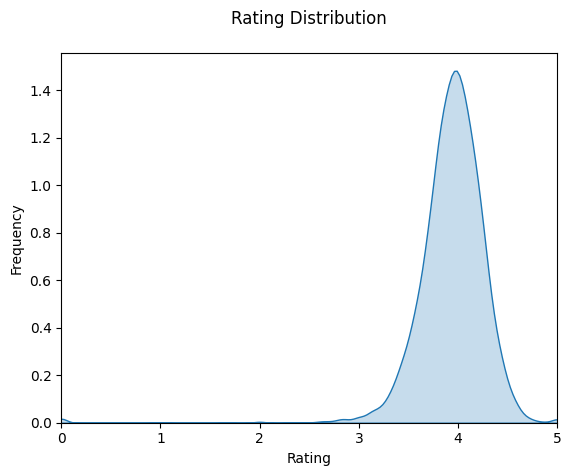

In [120]:
# ratings distribution
sns.kdeplot(df['average_rating'], shade = True)
plt.title('Rating Distribution\n')
plt.xlim((0, 5))
plt.xlabel('Rating')
plt.ylabel('Frequency')

In [121]:
df['ratings_count'].describe()

count    1.112700e+04
mean     1.793641e+04
std      1.124794e+05
min      0.000000e+00
25%      1.040000e+02
50%      7.450000e+02
75%      4.993500e+03
max      4.597666e+06
Name: ratings_count, dtype: float64

Text(0, 0.5, 'Frequency')

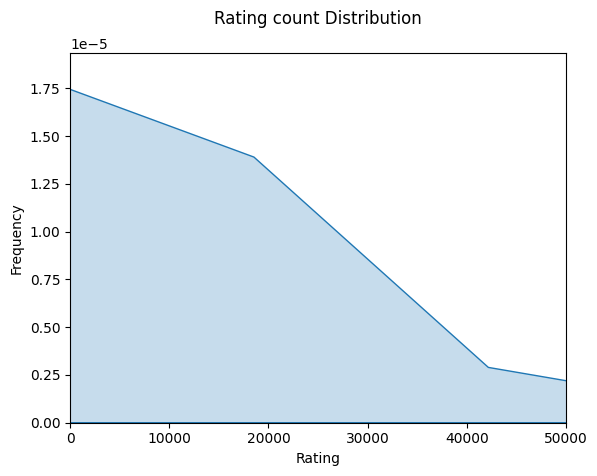

In [122]:
# ratings distribution
sns.kdeplot(df['ratings_count'], shade = True)
plt.title('Rating count Distribution\n')
plt.xlim((0, 50000))
plt.xlabel('Rating')
plt.ylabel('Frequency')

## Pages

Text(0, 0.5, 'Frequency')

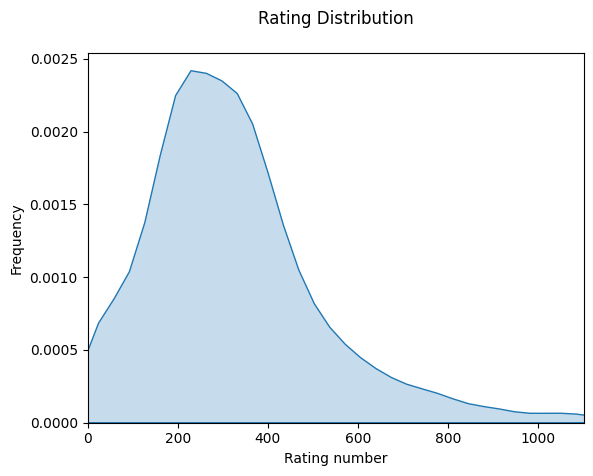

In [123]:
# ratings distribution
sns.kdeplot(df['num_pages'], shade = True)
plt.title('Rating Distribution\n')
plt.xlim((0, 1100))
plt.xlabel('Rating number')
plt.ylabel('Frequency')

(0.0, 6904.8)

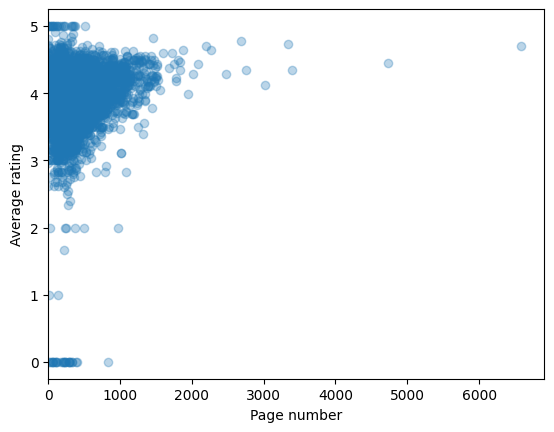

In [124]:
plt.scatter(df['num_pages'], df['average_rating'], marker='o',alpha = 0.3)
plt.xlabel('Page number')
plt.ylabel('Average rating')
plt.xlim(0)

(0.0, 2000.0)

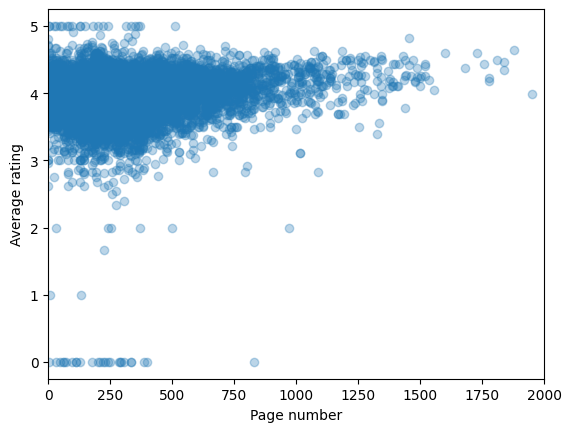

In [125]:
plt.scatter(df['num_pages'], df['average_rating'], marker='o',alpha = 0.3)
plt.xlabel('Page number')
plt.ylabel('Average rating')
plt.xlim((0,2000))

There is a slight correlation between page number & average. Especially after 500 pages

## Language

In [126]:
df['language_code'].value_counts()

language_code
eng      8911
en-US    1409
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: count, dtype: int64

In [127]:
df_language = pd.DataFrame({'average_rating' : df.groupby(by=['language_code'])['average_rating'].mean(), 'count_rating': df.groupby(by=['language_code'])['language_code'].count() }).reset_index()
df_language.sort_values(by=['count_rating'],ascending=False)

,language_code,average_rating,count_rating
5,eng,3.933546,8911
4,en-US,3.914422,1409
21,spa,3.929312,218
3,en-GB,3.923411,214
7,fre,3.971528,144
8,ger,3.950101,99
13,jpn,4.268696,46
16,mul,4.126316,19
26,zho,4.456429,14
11,grc,3.707273,11


Interesting thing here, where top 6 language which appear the most has around 3.9 average rating. So if we want to be precise in our model we need to predict to within **0.1**

## Publisher / Authors

In [128]:
(df['publisher'].value_counts() > 5).sum()

364

## Global

<Axes: >

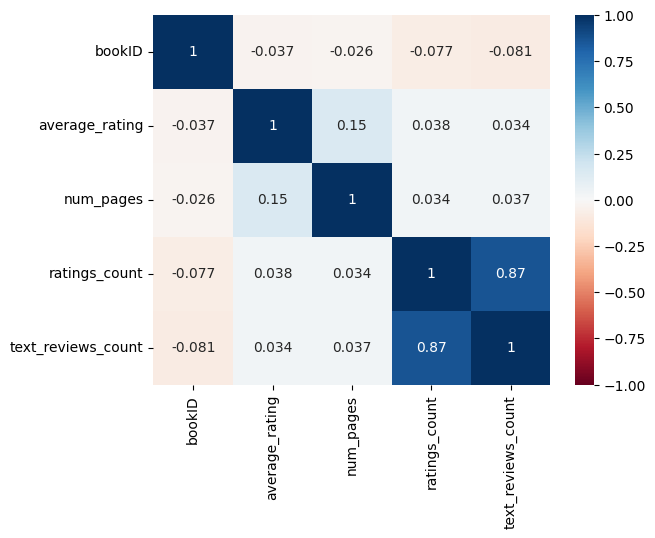

In [129]:
## Drop qualitative columns for corr matrix 
corr_matrix = df.drop(columns=['title','authors','language_code','publication_date','publisher']).corr()
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True)

# Preprocessing

## Drop duplicates

In [130]:
print(df.shape)
df = df.drop_duplicates(subset=['title'])
print(df.shape)

(11127, 10)
(10352, 10)


## Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x19441b17e90>,
 'caps': [<matplotlib.lines.Line2D at 0x19441b1d290>,
 'boxes': [<matplotlib.lines.Line2D at 0x19441b17510>],
 'medians': [<matplotlib.lines.Line2D at 0x19441b1e2d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x19441b1ea90>],
 'means': []}

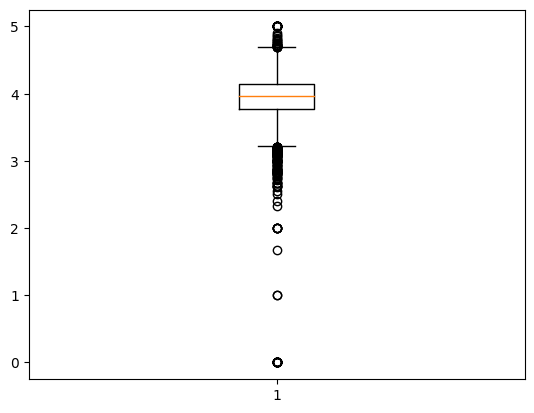

In [131]:
plt.boxplot(df['average_rating'])

{'whiskers': [<matplotlib.lines.Line2D at 0x19441b881d0>,
 'caps': [<matplotlib.lines.Line2D at 0x19441b89510>,
 'boxes': [<matplotlib.lines.Line2D at 0x19441b57bd0>],
 'medians': [<matplotlib.lines.Line2D at 0x19441b8a6d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x19441b89250>],
 'means': []}

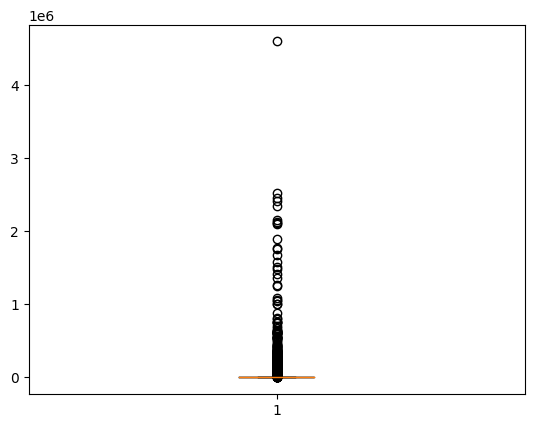

In [132]:
plt.boxplot(df['ratings_count'])

In [133]:
print(df.shape)
df= df.drop(df.index[df['ratings_count'] >= 1000000])
print(df.shape)

(10352, 10)
(10328, 10)


{'whiskers': [<matplotlib.lines.Line2D at 0x19441bdda50>,
 'caps': [<matplotlib.lines.Line2D at 0x19441bdeb10>,
 'boxes': [<matplotlib.lines.Line2D at 0x19441bdd110>],
 'medians': [<matplotlib.lines.Line2D at 0x19441bdfc90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1944165c550>],
 'means': []}

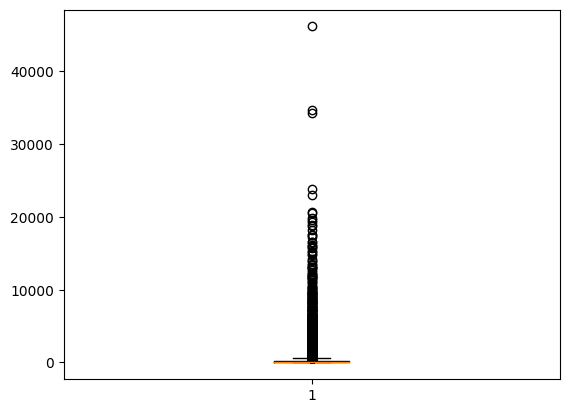

In [134]:
plt.boxplot(df['text_reviews_count'])

In [135]:
print(df.shape)
df = df.drop(df.index[df['text_reviews_count'] >= 20000])
print(df.shape)

(10328, 10)
(10321, 10)


{'whiskers': [<matplotlib.lines.Line2D at 0x194416a2650>,
 'caps': [<matplotlib.lines.Line2D at 0x194416a37d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x194416a1dd0>],
 'medians': [<matplotlib.lines.Line2D at 0x194416b49d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x194416b5190>],
 'means': []}

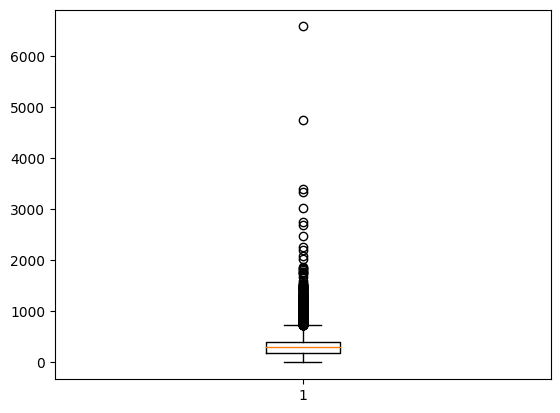

In [136]:
plt.boxplot(df['num_pages'])

In [137]:
print(df.shape)
df = df.drop(df.index[df['text_reviews_count'] >= 2000])
print(df.shape)

(10321, 10)
(9801, 10)


## Language

### Modify lang code which appear the least and replace by "others" 

In [138]:
df['language_code'].value_counts()

language_code
eng      7752
en-US    1305
spa       197
en-GB     190
fre       132
ger        94
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
lat         3
enm         3
rus         2
swe         2
nl          1
ara         1
srp         1
msa         1
glg         1
wel         1
nor         1
tur         1
gla         1
Name: count, dtype: int64

In [139]:
top_lang = df['language_code'].value_counts().head(6).index
top_lang

Index(['eng', 'en-US', 'spa', 'en-GB', 'fre', 'ger'], dtype='object', name='language_code')

In [140]:
mask = ~df['language_code'].isin(top_lang)
df.loc[mask,'language_code'] = 'others'

In [141]:
df['language_code'].value_counts()

language_code
eng       7752
en-US     1305
spa        197
en-GB      190
fre        132
others     131
ger         94
Name: count, dtype: int64

### One-Hot-Encoding

In [142]:
df = pd.get_dummies(df
               ,columns = ['language_code']
               ,drop_first = True,
               dtype=int
               )

In [143]:
df.sample(1)

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,publisher,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_others,language_code_spa
5842,21932,Hot Springs (Earl Swagger #1),Stephen Hunter/Jay O. Sanders,4.13,0,3,0,6/1/2000,Simon & Schuster Audio,0,1,0,0,0,0


## Year

In [144]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

In [145]:
df.isnull().sum()

bookID                  0
title                   0
authors                 0
average_rating          0
num_pages               0
ratings_count           0
text_reviews_count      0
publication_date        2
publisher               0
language_code_en-US     0
language_code_eng       0
language_code_fre       0
language_code_ger       0
language_code_others    0
language_code_spa       0
dtype: int64

In [146]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(9801, 15)
(9799, 15)


In [147]:
df['publication_year'] = pd.DatetimeIndex(df['publication_date']).year

In [148]:
df.drop(columns=['publication_date'],inplace=True)

In [149]:
df.sample(1)

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_others,language_code_spa,publication_year
2555,9423,The Secret Dreamworld of a Shopaholic (Shopaho...,Sophie Kinsella,3.64,320,2214,249,Transworld Publishers,0,1,0,0,0,0,2000


## Qualitative data to label 

In [150]:
## Label encode title 
le = preprocessing.LabelEncoder()
df['title'] = le.fit_transform(df['title'])
df['title'].value_counts().head(10)

title
2908    1
231     1
6537    1
2108    1
8174    1
1674    1
8117    1
5188    1
5235    1
1982    1
Name: count, dtype: int64

In [151]:
## Label encode authors
df['authors'] = le.fit_transform(df['title'])
df['authors'].value_counts().head(10)

authors
2908    1
231     1
6537    1
2108    1
8174    1
1674    1
8117    1
5188    1
5235    1
1982    1
Name: count, dtype: int64

In [152]:
## Label encode authors
df['publisher'] = le.fit_transform(df['publisher'])
df['publisher'].value_counts().head(10)

publisher
2001    275
1388    197
1147    139
1403    137
170     130
841     100
1469     98
173      96
832      95
1970     87
Name: count, dtype: int64

## Split train / test

In [153]:
df.dtypes

bookID                    int64
title                     int32
authors                   int64
average_rating          float64
num_pages                 int64
ratings_count             int64
text_reviews_count        int64
publisher                 int32
language_code_en-US       int32
language_code_eng         int32
language_code_fre         int32
language_code_ger         int32
language_code_others      int32
language_code_spa         int32
publication_year          int32
dtype: object

In [154]:
## test wih less features
# df.drop(columns=['title','authors','publisher','publication_year'])

In [155]:
df.drop(columns=['bookID']).to_csv('book_rate.csv',index=False)

In [156]:
y = df.pop('average_rating')

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['bookID']), y, test_size=0.3, random_state=42)

In [157]:
y_train.count()

6859

In [158]:
y_test.count()

2940

# Models

In [159]:
global_result = pd.DataFrame(columns=['model name','RMSE','mae','r2_score'])

## Baseline  (Predict mean average rating)

In [160]:
len(y_test)

2940

In [161]:
mean_ratings = y_test.mean().round(2)
y_pred = np.full((len(y_test)), mean_ratings)
y_pred

array([3.93, 3.93, 3.93, ..., 3.93, 3.93, 3.93])

### Metrics

In [162]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')


# Create dictionnary to aggregte all result 
dict = {'model name' : 'Baseline','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

RMSE : 0.36428417366621
mae : 0.23886054421768704
r2_score : -0.0


## Linear Regression

In [163]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [164]:
y_pred = lr.predict(X_test)

### Metrics

In [165]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Linear regression','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(25))

RMSE : 0.3582178607173424
mae : 0.23257884467692155
r2_score : 0.03
    Actual  Predicted
0     3.58   3.915789
1     4.23   3.832040
2     3.97   3.920924
3     4.02   4.008585
4     2.83   3.996210
5     4.17   3.873565
6     4.38   3.915996
7     4.08   3.887465
8     4.18   3.844613
9     3.95   3.957518
10    4.00   3.854975
11    3.98   3.840566
12    4.14   3.913407
13    4.15   3.878230
14    4.39   4.055659
15    3.89   3.997397
16    3.86   3.937957
17    3.72   3.918377
18    3.93   3.963130
19    3.85   3.970276
20    4.04   3.869087
21    3.78   3.881106
22    3.91   3.901666
23    4.15   3.941525
24    3.94   3.943779


## Random Forest

In [166]:
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [7, 10, 12, 15],
    'min_samples_split': [2,5],
    'min_samples_leaf': [5, 10, 15]
}
regr = RandomForestRegressor(random_state=0)

In [167]:
clf = GridSearchCV(estimator = regr, param_grid = parameters,cv=3,verbose=2, n_jobs = -1)

In [168]:
clf.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [169]:
clf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [170]:
best_rf = clf.best_estimator_
y_pred = clf.predict(X_test)

### Metrics

In [171]:
importance_feature = pd.DataFrame(best_rf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
importance_feature.sort_values(by=['Importance'],ascending=True,inplace=True)
importance_feature

,Importance
language_code_ger,0.000017
language_code_spa,0.000253
language_code_fre,0.001786
language_code_en-US,0.001929
language_code_eng,0.004037
language_code_others,0.006143
title,0.040135
authors,0.044739
publication_year,0.055117
text_reviews_count,0.074895


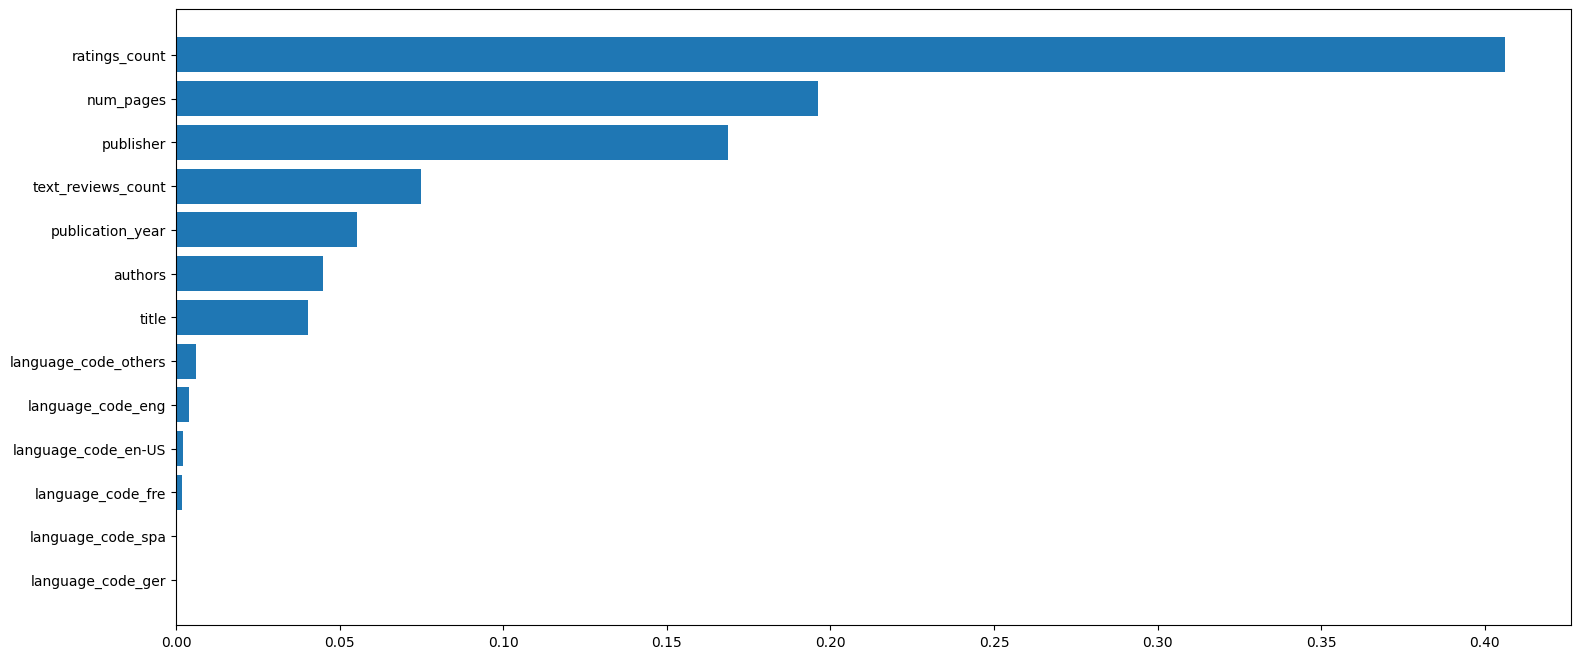

In [172]:
plt.figure(figsize=(18,8))
plt.barh(y=importance_feature.index,width=importance_feature.values.reshape((-1,)))
plt.show()

In [173]:
### Metrics
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Random Forest','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(5))

RMSE : 0.3386293723837646
mae : 0.22312278747973868
r2_score : 0.14
   Actual  Predicted
0    3.58   3.643356
1    4.23   3.963156
2    3.97   3.823015
3    4.02   3.994898
4    2.83   3.764368


In [174]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
pred.head(5)

,Actual,Predicted
0,3.58,3.643356
1,4.23,3.963156
2,3.97,3.823015
3,4.02,3.994898
4,2.83,3.764368


## XGBoost

In [175]:
xgb = XGBRegressor()

In [176]:
parameters = {'nthread':[6],
              'objective':['reg:linear'],
              'learning_rate': [0.01,.03], #so called `eta` value
              'max_depth': [5,7,15],
              'subsample': [0.5],
              'n_estimators': [500,1000]}

In [177]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [178]:
xgb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[09:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.03], 'max_depth': [5, 7, 15],
                         'n_estimators': [500, 1000], 'nthread': [6],
                         'objective': ['reg:linear'], 'subsample': [0.5]},
             verbose=True)

In [179]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.1821383937453792
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'nthread': 6, 'objective': 'reg:linear', 'subsample': 0.5}


In [180]:
optimal_xgb = xgb_grid.best_estimator_

In [181]:
y_pred = optimal_xgb.predict(X_test)

In [182]:
### Metrics
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'XGBoost','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)

RMSE : 0.3375998450643799
mae : 0.2209831148561369
r2_score : 0.14


[0.06025795 0.         0.10169743 0.11035676 0.05572253 0.09699965
 0.03624905 0.11848253 0.05743627 0.16047563 0.08547276 0.03167604
 0.08517345]


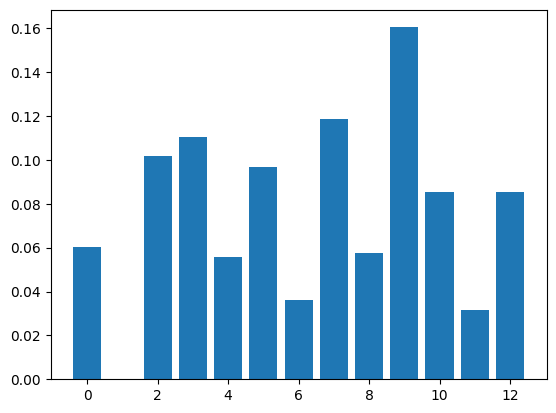

In [183]:
# feature importance
print(optimal_xgb.feature_importances_)
# plot
pyplot.bar(range(len(optimal_xgb.feature_importances_)), optimal_xgb.feature_importances_)
pyplot.show()

# Global result

In [184]:
global_result

,model name,RMSE,mae,r2_score
0,Baseline,0.364284,0.238861,-0.0
1,Linear regression,0.358218,0.232579,0.03
2,Random Forest,0.338629,0.223123,0.14
3,XGBoost,0.3376,0.220983,0.14


In [185]:
df.drop(columns=['bookID']).to_csv('book_rate.csv',index=False)